In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import Libraries.dataloader as dl
from torchviz import make_dot
import random


import segmentation_models_pytorch as smp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [3]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 10000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/10)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [4]:
# from Libraries.dataloader import DataLoader as DL

# DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
# dl = DL()

# X_A, y_A = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')
# X_B, y_B = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_ArUco.csv', 'files_ArUco/axis', 'S')

# X_trainA, X_validationA, y_trainA, y_validationA = train_test_split(X_A, y_A, test_size=0.2, random_state=101)
# X_trainB, X_validationB, y_trainB, y_validationB = train_test_split(X_B, y_B, test_size=0.03, random_state=101)

# X_train = torch.cat((X_trainA, X_trainB),axis=0)
# y_train = torch.cat((y_trainA, y_trainB),axis=0)

# X_train_aug = X_train.clone()
# for i in range(X_train_aug.shape[0]):
#      X_train_aug[i] = DataAug(X_train_aug[i])
        
# X_train = torch.cat((X_train, X_train_aug),axis=0)
# y_train = torch.cat((y_train, y_train),axis=0)

# X_validation = torch.cat((X_validationA, X_validationB),axis=0)
# y_validation = torch.cat((y_validationA, y_validationB),axis=0)

In [5]:
from Libraries.dataloader import DataLoader as DL

DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X, y = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=101)

X_train_aug = X_train.clone()
for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
X_train = torch.cat((X_train, X_train_aug),axis=0)
y_train = torch.cat((y_train, y_train),axis=0)


In [6]:
X_test, y_test = dl.load(DATASET_ROOTDIR, 'files_Test/data_Test.csv', 'files_Test/axis', 'S')

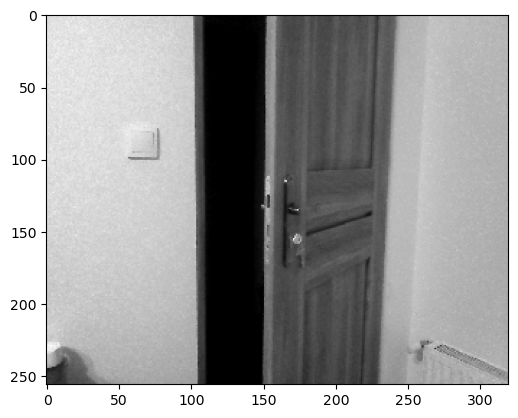

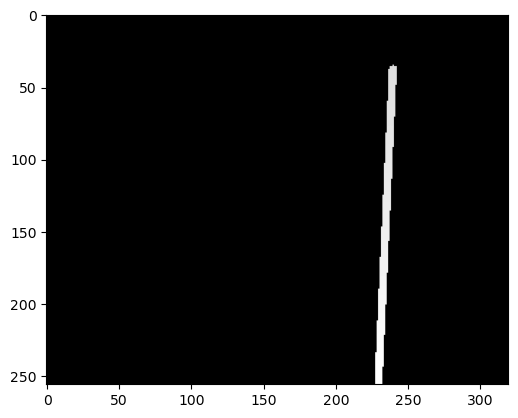

In [35]:
plt.figure()
plt.imshow(X_test[2][0].cpu().detach().numpy(), cmap='gray')

plt.figure()
plt.imshow(y_test[2][0].cpu().detach().numpy(),cmap='gray')

In [36]:
X_test.shape

torch.Size([33, 3, 256, 320])

In [7]:
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_validation, y_validation)
test_set = TensorDataset(X_test, y_test)

loader_args = dict(batch_size=6, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_set,shuffle=True, **loader_args)
val_loader = DataLoader(val_set,shuffle=False, **loader_args)
test_loader = DataLoader(test_set,shuffle=False, **loader_args)

In [9]:
# class AoRModel(nn.Module):
#     def __init__(self,pretrained=False ,input_channels=6, output_size=1):
#         super().__init__()
#         self.unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana',pretrained=False, scale=0.5)
#         self.unet.inc.double_conv[0] = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#         self.unet.outc.conv = nn.Conv2d(in_channels=64, out_channels=output_size, kernel_size=(1, 1), stride=(1, 1))
#     def forward(self, X):
#         return self.unet(X)

In [8]:
amp=False
device='cuda'

In [9]:
# Model = AoRModel().to(device)
# Model = UNet3D(n_channels=6, n_classes=1,trilinear=False).to(device)
Model = smp.Unet(in_channels=3, classes=1,encoder_weights=None,
                         encoder_name='timm-resnest50d').to(device)
print(Model)

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [12]:
# ModelCutter = AoRModel(input_channels=7).to(device)

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [10]:
criterion = smp.losses.DiceLoss(mode='binary')
quality_check = nn.MSELoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10, min_lr=0.0000001)

In [54]:
epochs = 60

train_losses = []
validation_losses = []

Model.train()
for epoch in range(epochs):
    # Run the training batches
    for batch, (images, true_mask) in enumerate(train_loader):
        batch+=1
        
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        # Apply the model
        mask_prediction = Model(images)
        loss = criterion(mask_prediction, true_mask)
            
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if batch%1 == 0:
            print(f'epoch: {epoch+1:2}  batch: {batch}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    
    # Run the validationing batches
    with torch.no_grad():
        for batch, (images, true_mask) in enumerate(val_loader):
            batch+=1

            images = images.to(device=device)
            true_mask = true_mask.to(device=device)

            # Apply the model
            mask_pred = Model(images)
            loss = criterion(mask_pred, true_mask)

    validation_losses.append(loss.cpu().detach().numpy())

epoch:  1  batch: 1  loss: -0.18933785
epoch:  1  batch: 2  loss: -0.25286973
epoch:  1  batch: 3  loss: -0.17151749
epoch:  1  batch: 4  loss: -0.18428993
epoch:  1  batch: 5  loss: -0.26459777
epoch:  1  batch: 6  loss: -0.25481880
epoch:  1  batch: 7  loss: -0.10613394
epoch:  1  batch: 8  loss: -0.23122013
epoch:  1  batch: 9  loss: -0.29363871
epoch:  1  batch: 10  loss: -0.27391672
epoch:  1  batch: 11  loss: -0.14671743


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

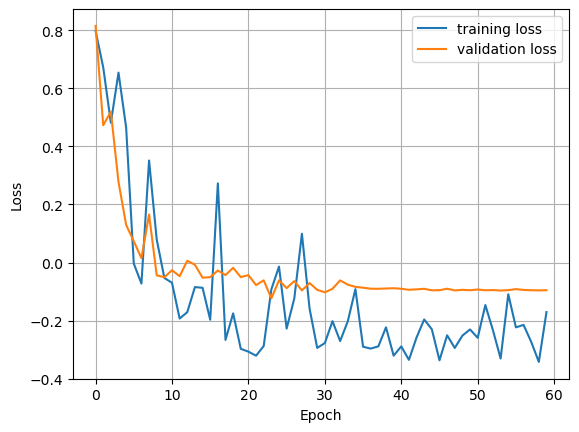

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [17]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# torch.save(Model.state_dict(), 'Modele/Small_UN1_60Epoch.pt')

In [19]:
# Model = AoRModel().to(device)
Model.load_state_dict(torch.load('Modele/Small_UN1_60Epoch.pt'))
Model.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [20]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

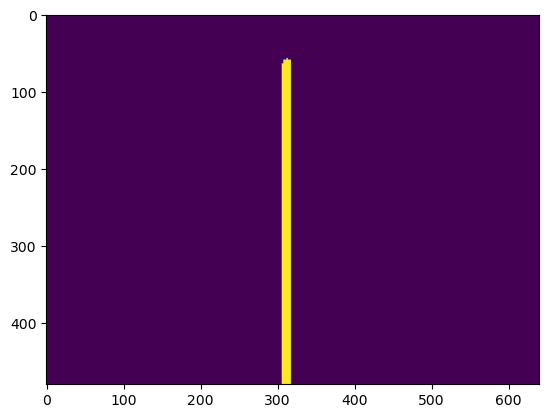

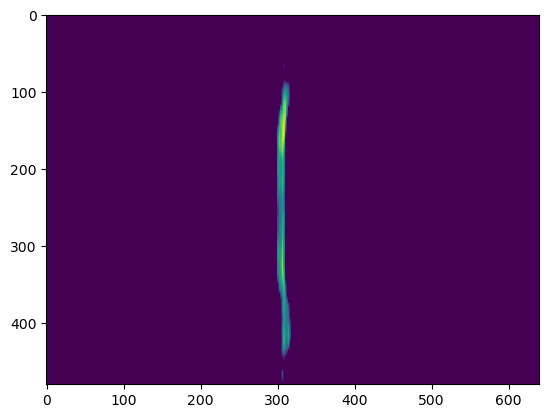

------------------------------------------------------------


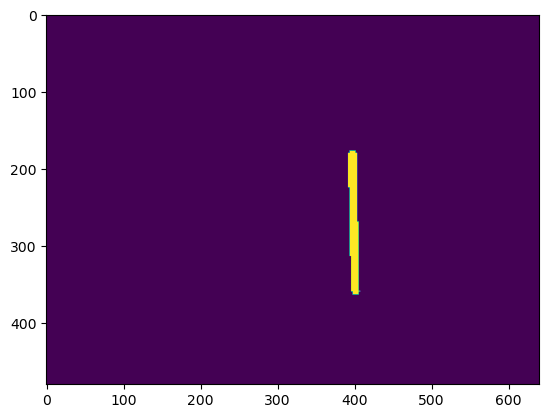

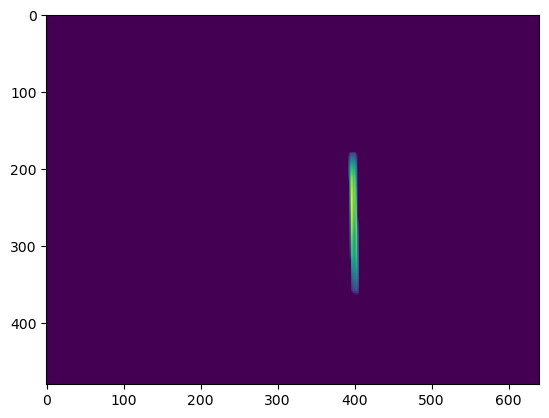

------------------------------------------------------------


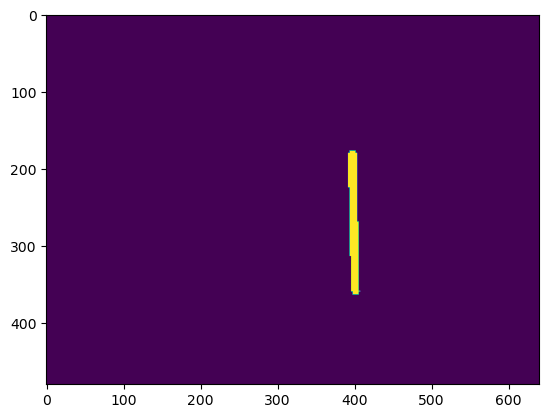

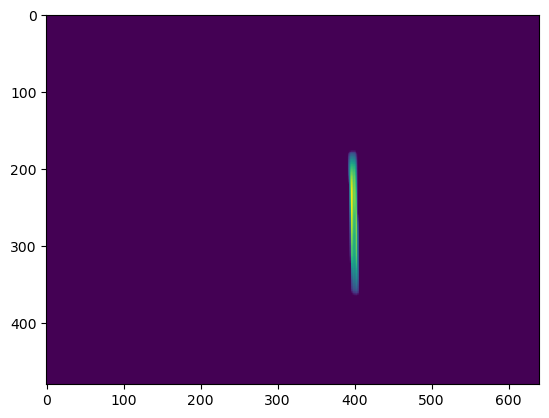

------------------------------------------------------------


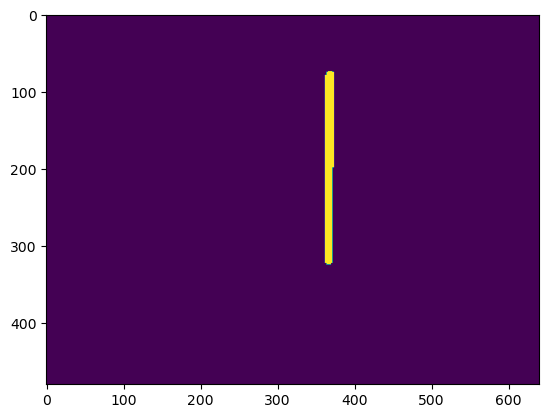

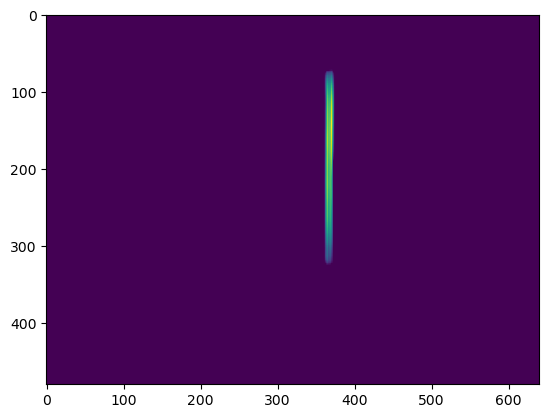

------------------------------------------------------------


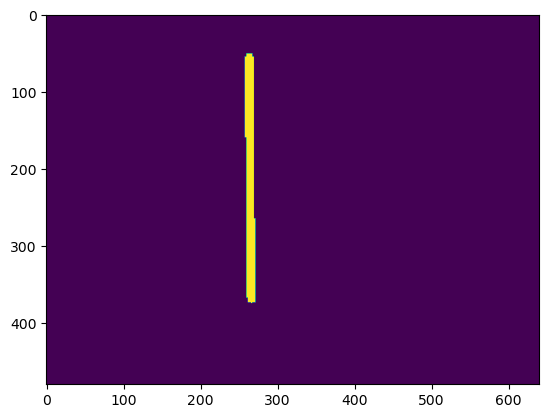

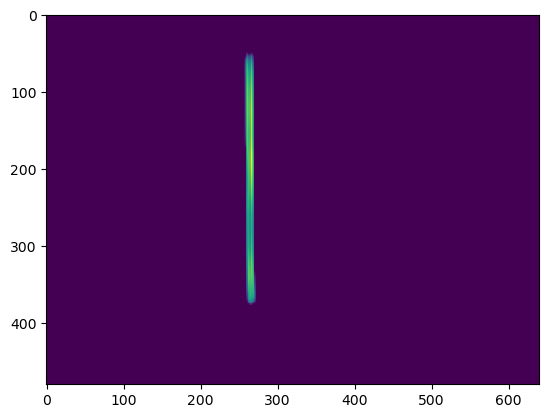

------------------------------------------------------------


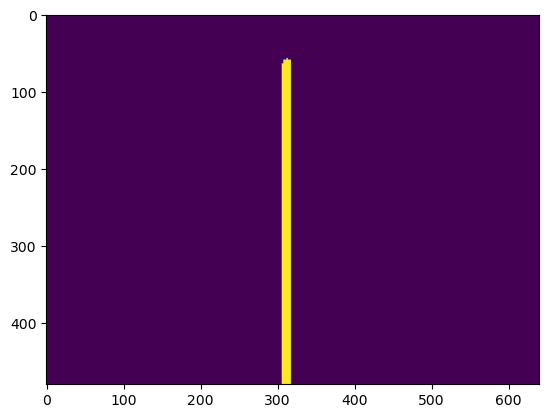

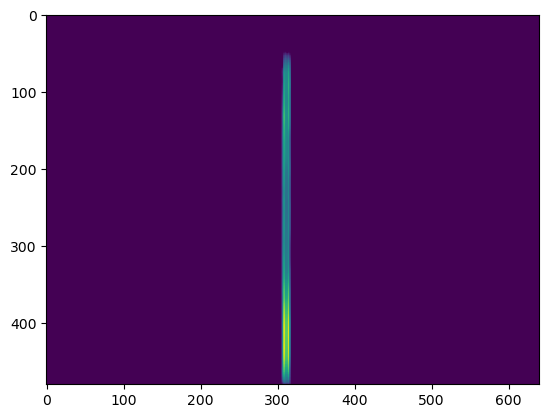

------------------------------------------------------------


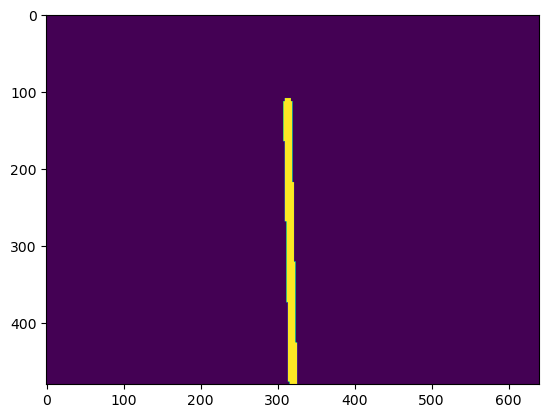

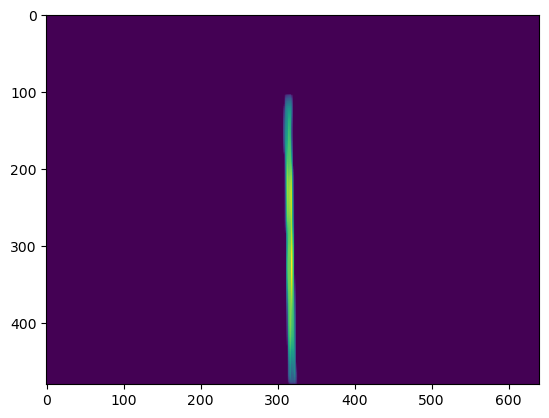

------------------------------------------------------------


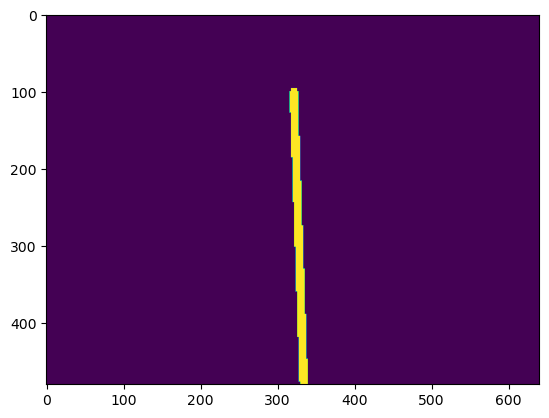

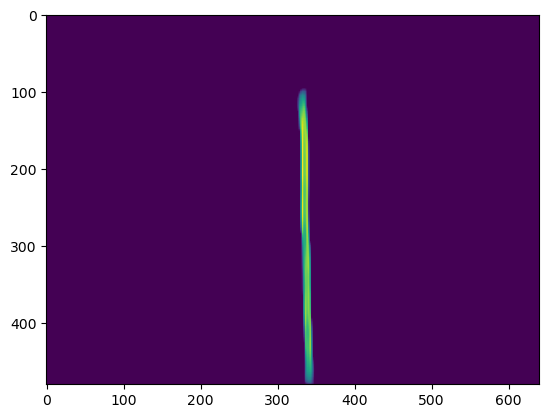

------------------------------------------------------------


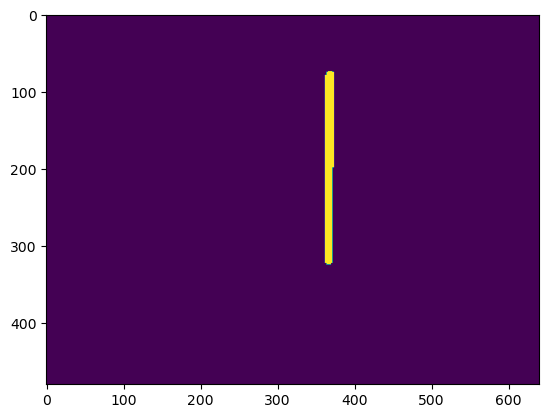

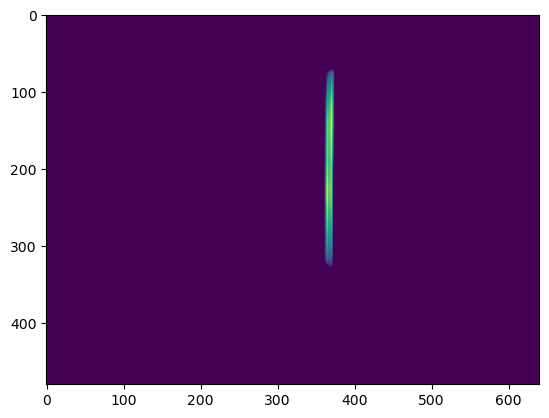

------------------------------------------------------------


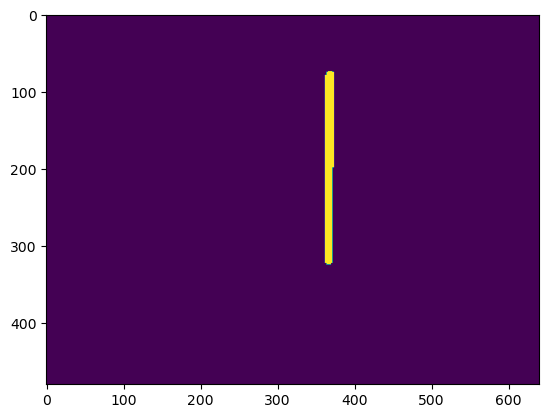

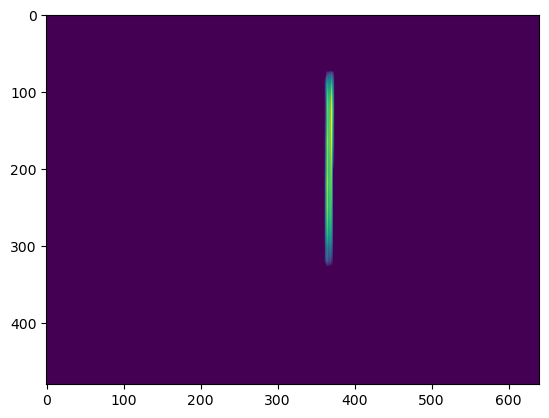

------------------------------------------------------------


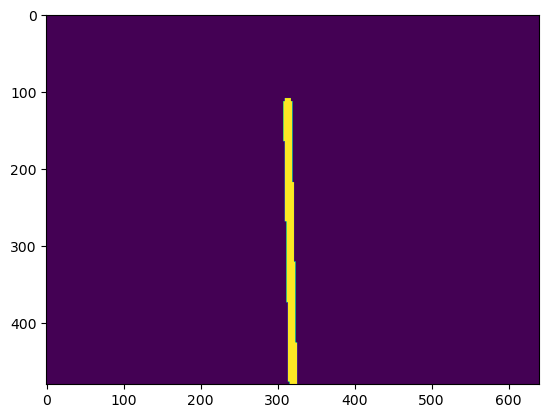

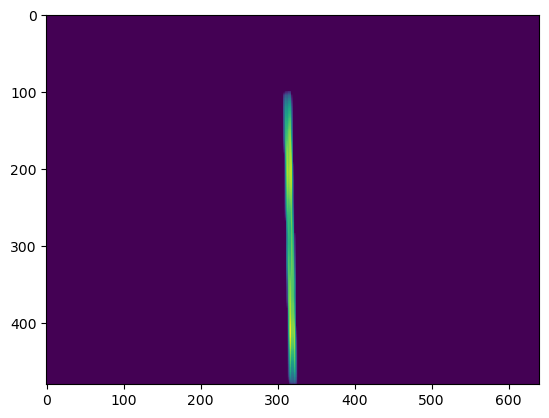

------------------------------------------------------------


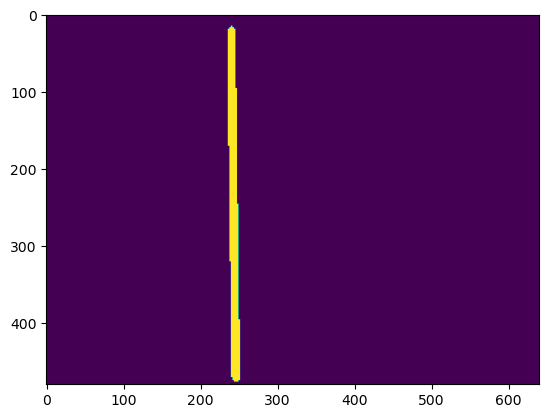

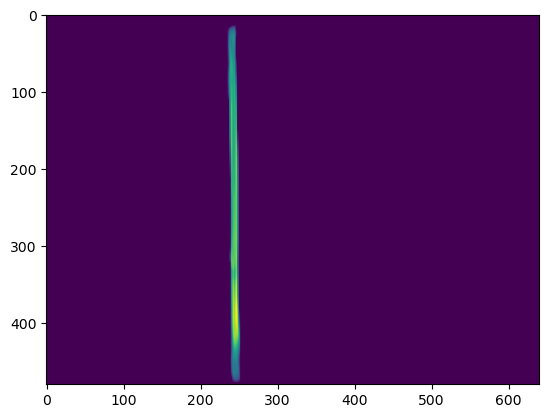

------------------------------------------------------------


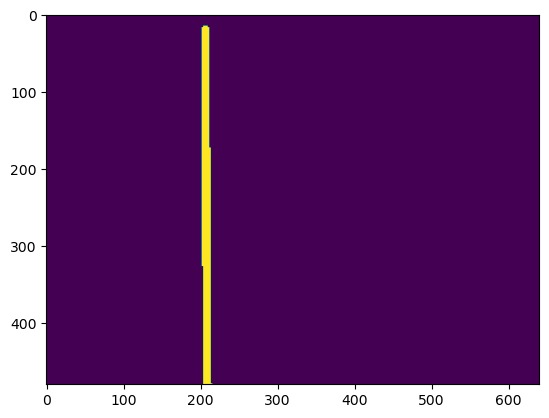

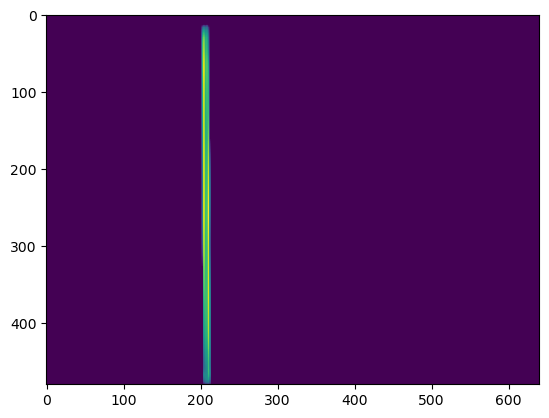

------------------------------------------------------------


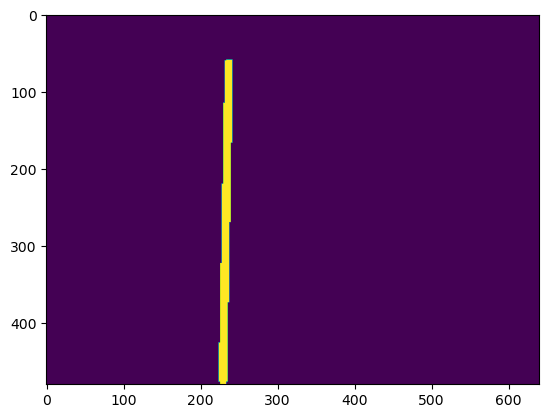

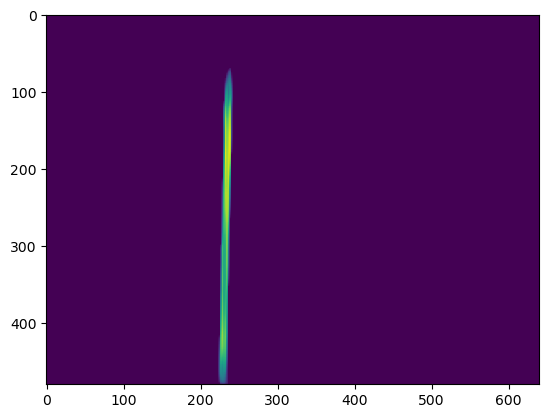

------------------------------------------------------------


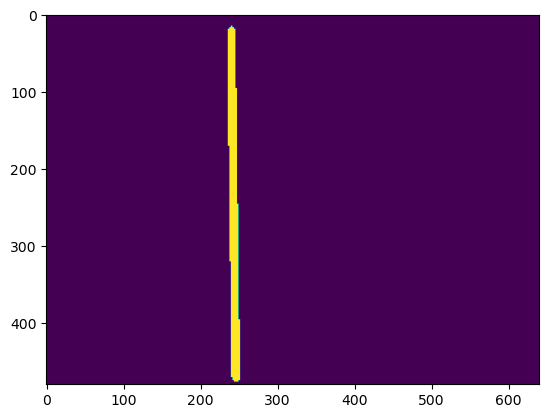

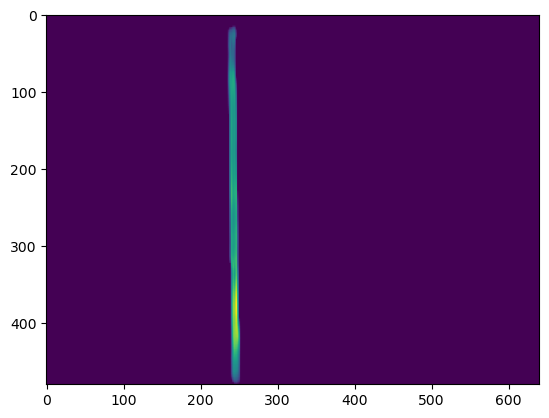

------------------------------------------------------------


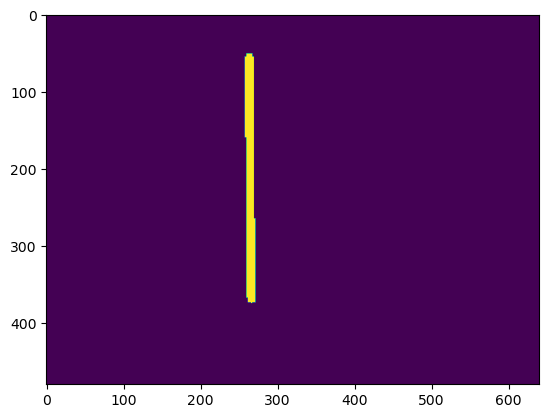

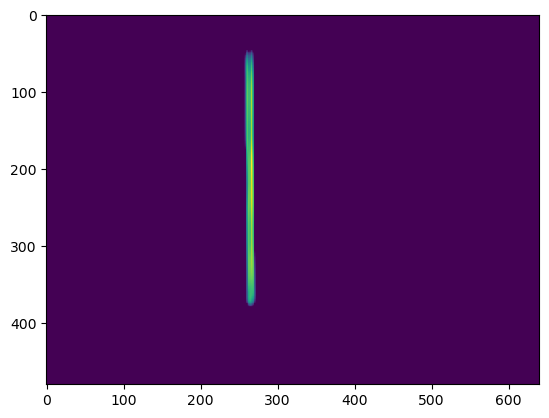

------------------------------------------------------------


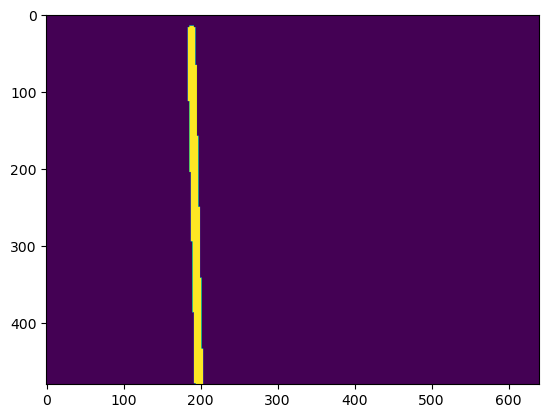

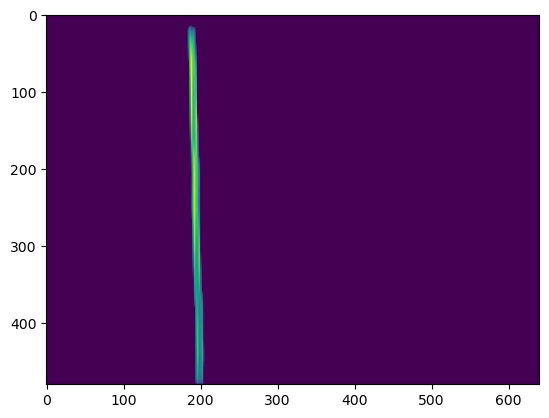

------------------------------------------------------------


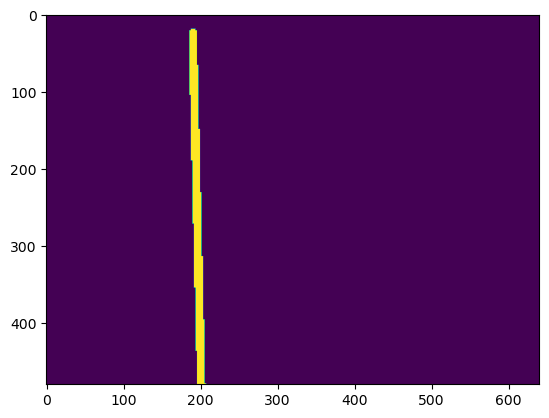

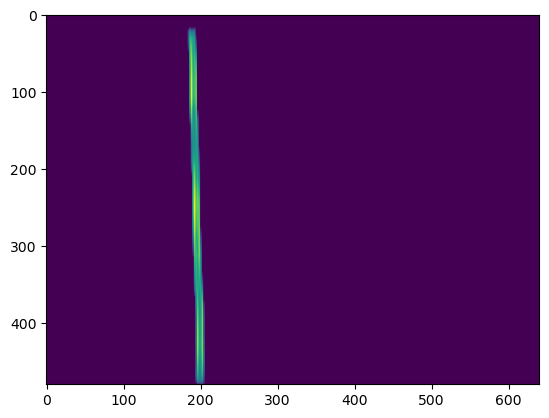

------------------------------------------------------------


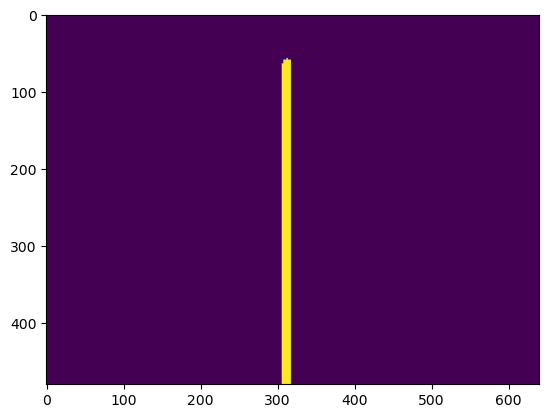

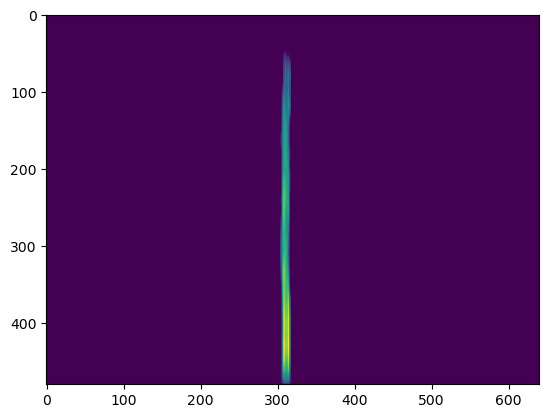

------------------------------------------------------------


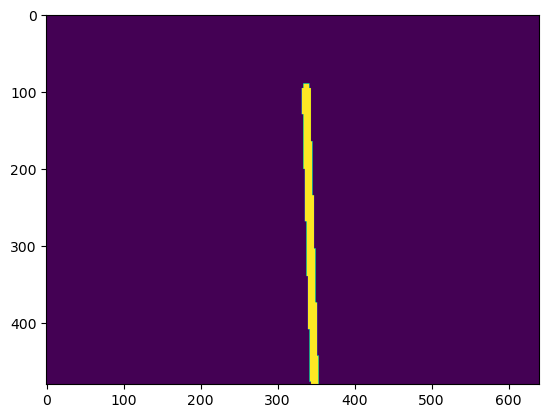

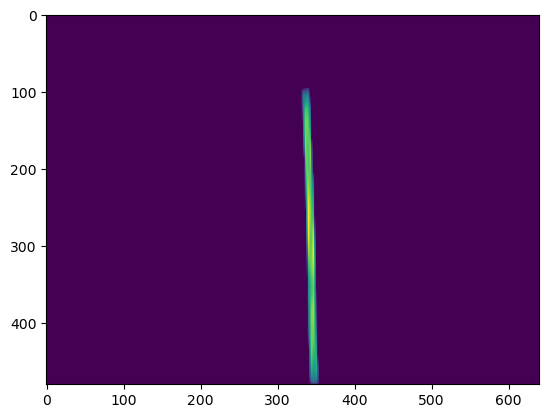

------------------------------------------------------------


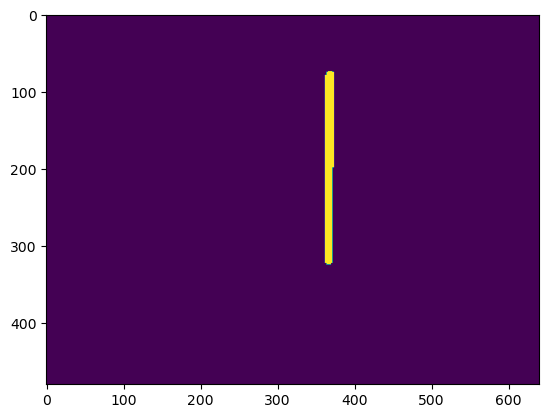

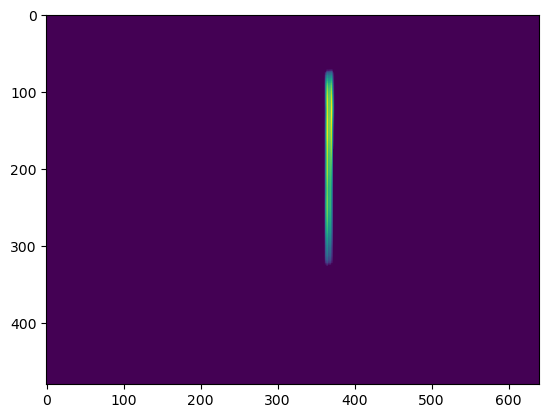

------------------------------------------------------------


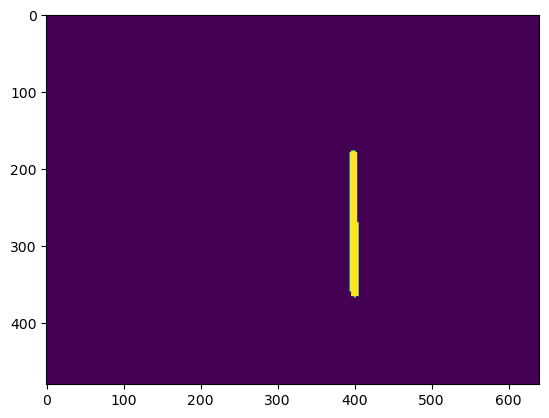

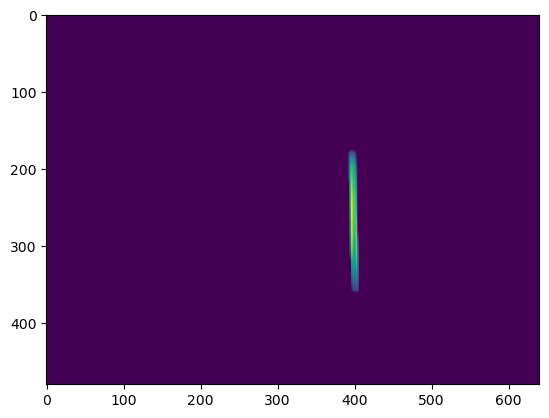

------------------------------------------------------------


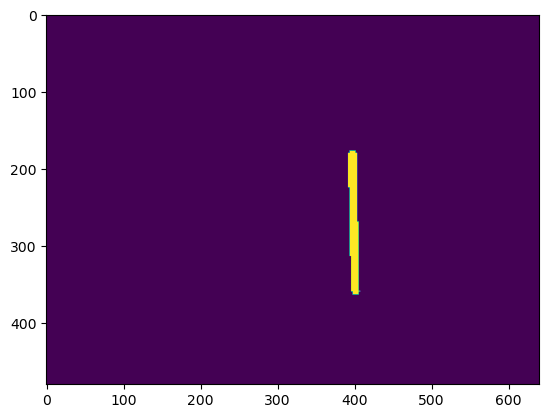

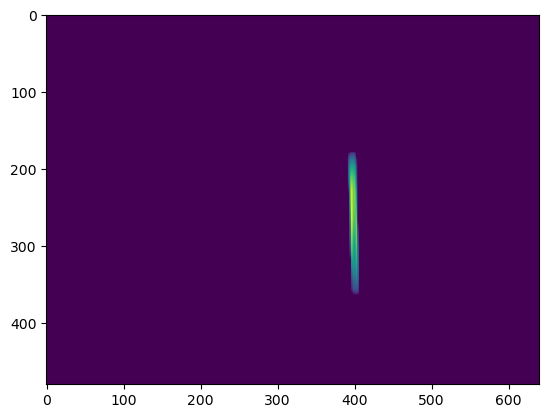

------------------------------------------------------------


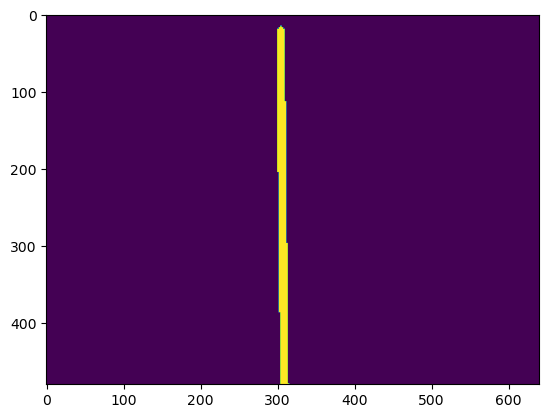

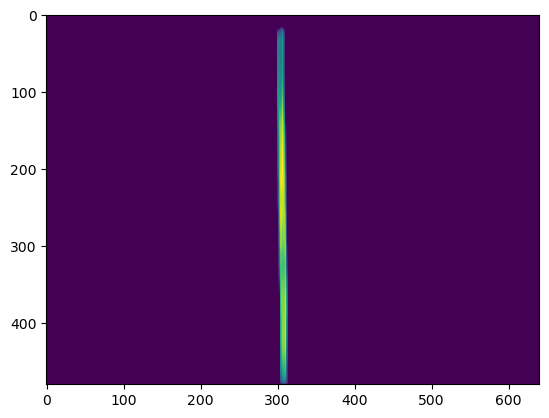

------------------------------------------------------------


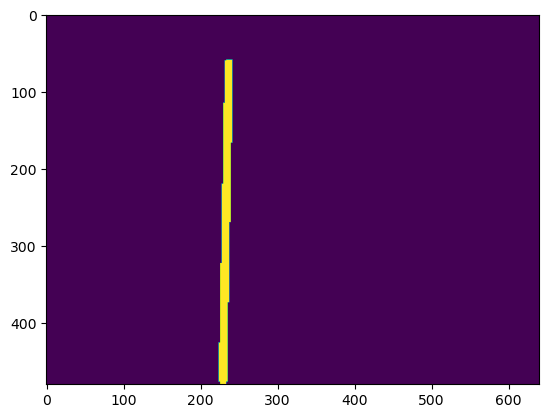

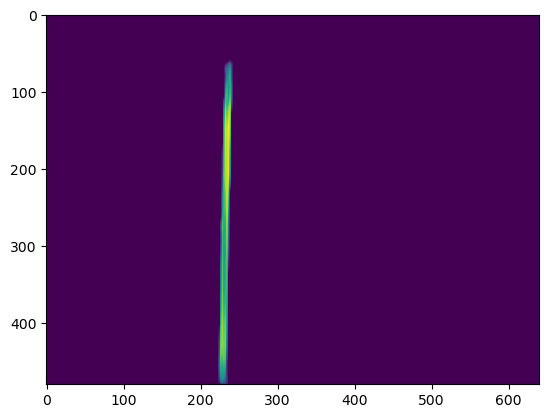

------------------------------------------------------------


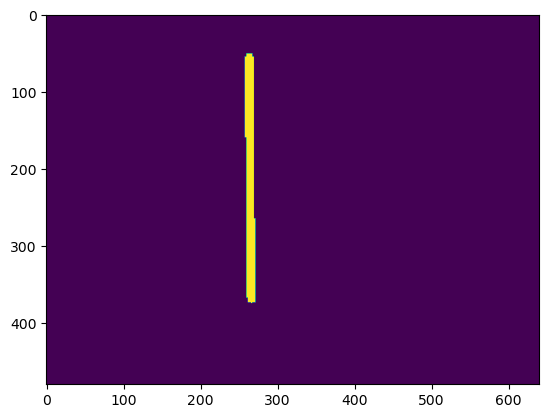

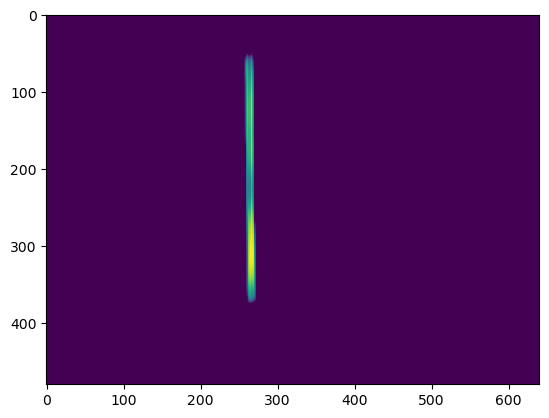

------------------------------------------------------------


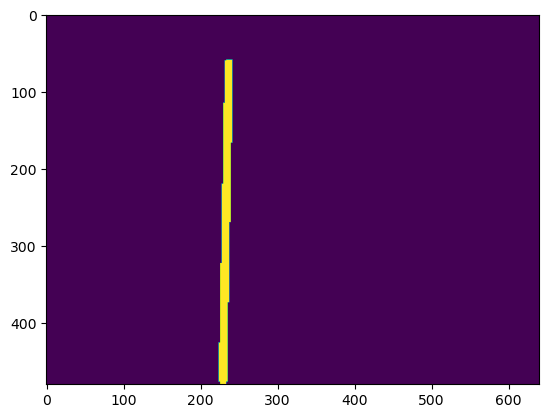

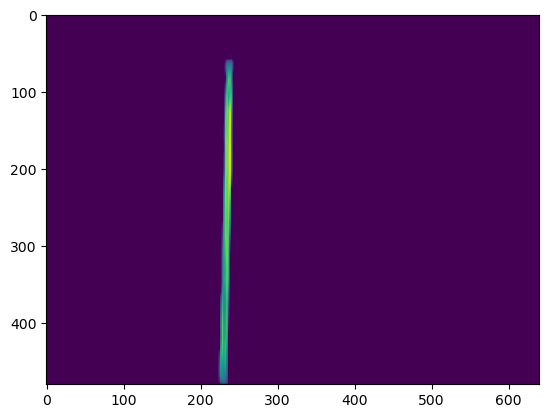

------------------------------------------------------------


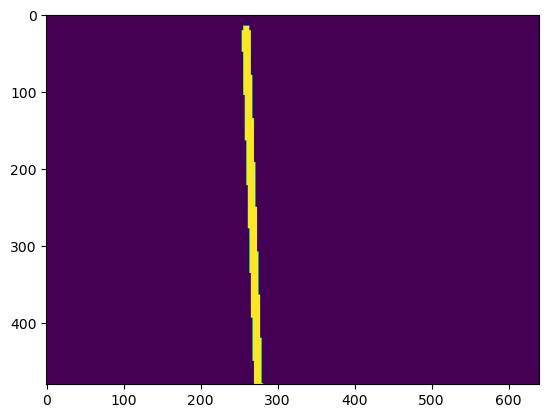

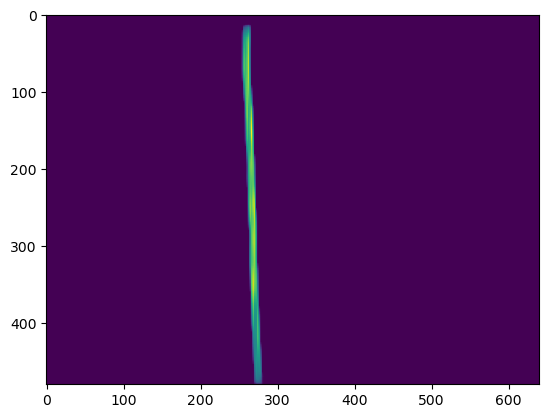

------------------------------------------------------------


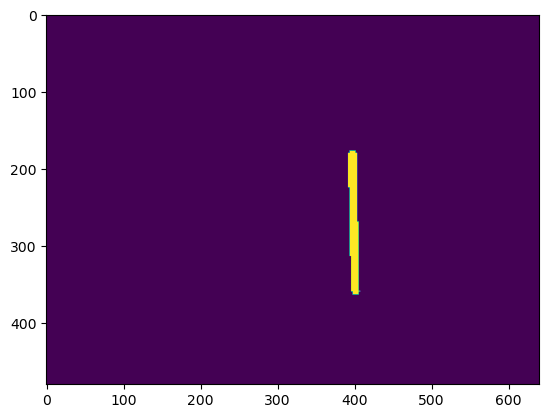

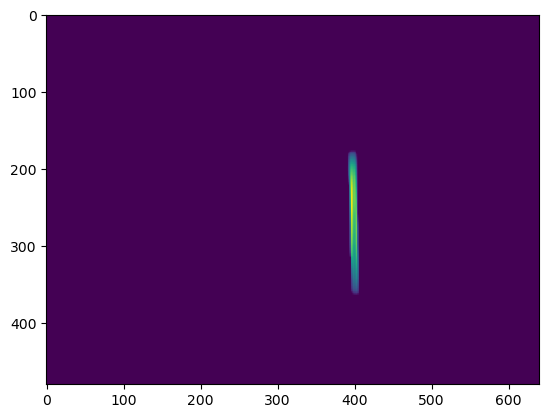

------------------------------------------------------------


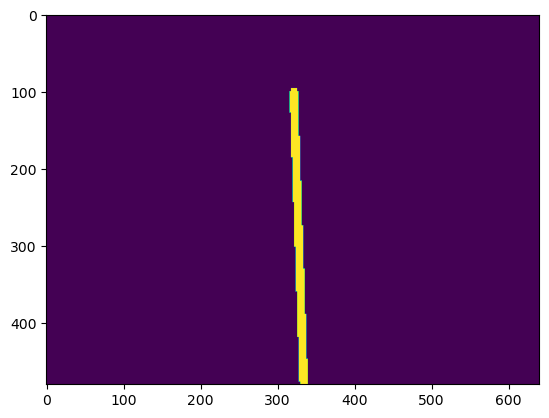

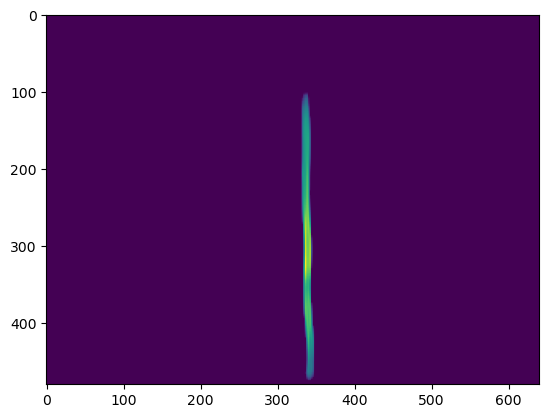

------------------------------------------------------------


In [24]:
val_err = []

with torch.no_grad():
    for b, (images, true_mask) in enumerate(val_loader):
#         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        y_val = Model(images)
        
#         todo
#         new_input = torch.cat((images, y_val), axis=1) 
#         print(new_input.shape)
        
        y_val = F.threshold(y_val, 1, 0)
        tp, fp, fn, tn = smp.metrics.get_stats(y_val.long(), true_mask.long(), mode='binary', threshold=0.1)
        err = smp.metrics.f1_score(tp, fp, fn, tn)
        val_err.append(err.cpu().detach().numpy())
        
        for j in range(y_val.shape[0]):
            images_buff = inv_resize(images[j])
            RGB_buff = images_buff[0].cpu().numpy()*255
#             print(RGB_buff.shape)
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = images_buff[1].cpu().numpy()*5500
            trueAxis_buff = inv_resize(true_mask[j].long()).cpu().detach().numpy().transpose(1,2,0)
            predAxis_buff = inv_resize(y_val[j]).cpu().detach().numpy().transpose(1,2,0)
            
            NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
            
#             new_axis[np.where(predAxis_buff > 1)] = minval
#             print(minval)
#             PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
#             PC_realAxis = CreateAxisCloud(trueAxis_buff)
#             PC_predAxis = CreateAxisCloud(predAxis_buff)
#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
#             o3d.visualization.draw_geometries([PC_object,PC_realAxis])

            plt.figure()
            plt.imshow(trueAxis_buff)
            
            plt.figure()
            plt.imshow(predAxis_buff)
            
            plt.show()
            print('------------------------------------------------------------')

In [25]:
np.mean(val_err) 

0.89508533

In [26]:
np.std(val_err)

0.22277097

# Save model

In [21]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# torch.save(Model.state_dict(), 'Modele/Large_UN_80Epoch.pt')

torch.Size([1, 1, 256, 320])


ValueError: cannot reshape array of size 921600 into shape (3,480,1)